In [4]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [5]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388

GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [44]:
def load_log(fname):
    log = np.genfromtxt(fname)
    _, indices = np.unique(log[:,0], return_index=True)
    log = log[sorted(indices)]
    return log

In [45]:
sfr = {}
Rs_list = ['116', '129', '142']
Vv_list = ['116', '129', '142']
ecc_list = ['04', '05', '06']
for Rs in Rs_list:
    sfr[Rs] = {}
    for Vv in Vv_list:
        sfr[Rs][Vv] = {}
        for ecc in ecc_list:
            key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
            sfr[Rs][Vv][ecc] = load_log(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output/sfr.txt')

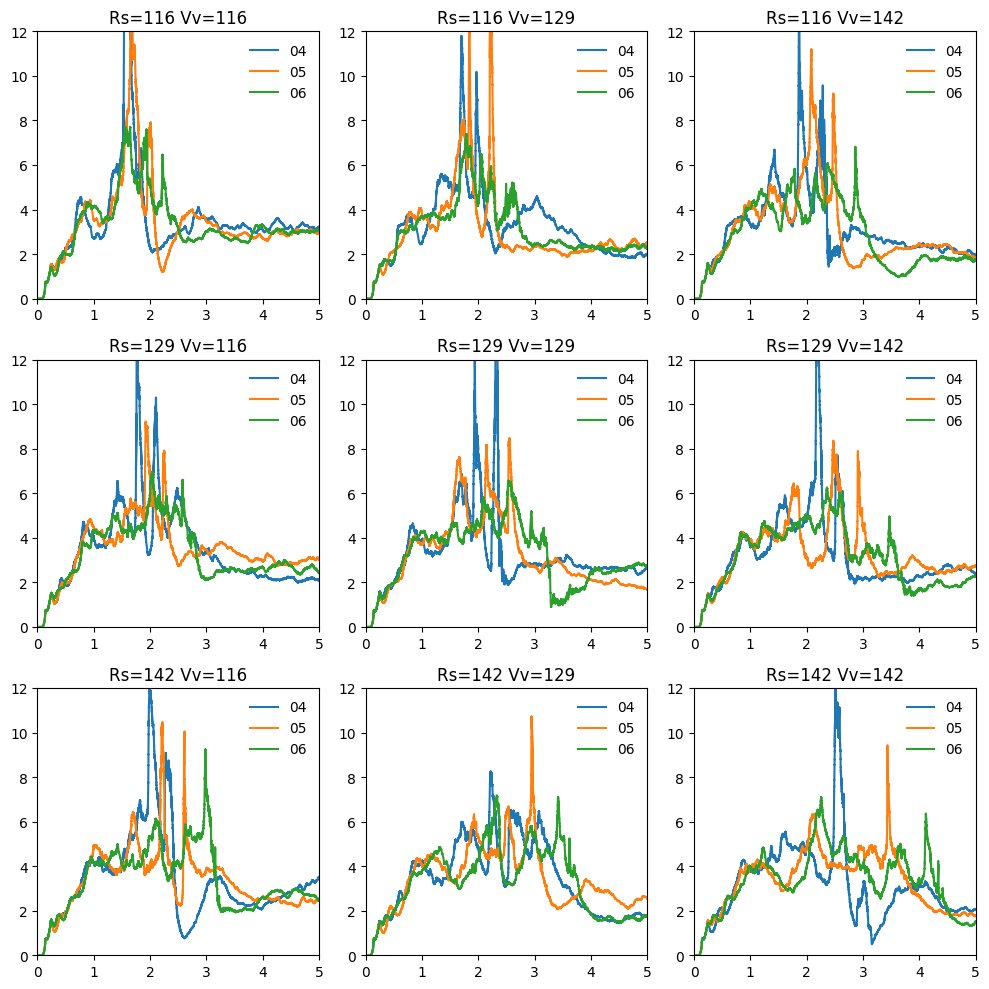

In [46]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i,Rs in enumerate(Rs_list):
    for j,Vv in enumerate(Vv_list):
        ax = axs[i][j]
        for ecc in ecc_list:
            ax.plot(sfr[Rs][Vv][ecc][:,0], sfr[Rs][Vv][ecc][:,2], label=ecc)
        
        ax.set(xlim=(0, 5), ylim=(0, 12), title='Rs='+Rs+' Vv='+Vv)
        ax.legend(frameon=False)

fig.tight_layout()

In [9]:
idx = 320

gals = {}
Rs_list = ['116', '129', '142']
Vv_list = ['116', '129', '142']
ecc_list = ['04', '05', '06']
for Rs in Rs_list:
    gals[Rs] = {}
    for Vv in tqdm(Vv_list):
        gals[Rs][Vv] = {}
        for ecc in ecc_list:
            key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
            gals[Rs][Vv][ecc] = galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)
gals['iso'] = galaxy.Galaxy(basepath + 'runs/MW7iso/lvl4-Ngb64/output', idx, orient=True)

100%|██████████| 3/3 [00:26<00:00,  9.00s/it]


In [10]:
def make_sequence_plot(logFeH, logMgFe, tform, keybool, title, 
              logFeH_lim, logMgFe_lim, logFeH0_list, dlogFeH0,
              offset, subsamp, tmax, save=False, show=True, fname=None,
              tbound0=2.5, tbound1=3.5):
    
    subsamp = 5000
    key_sub = np.where(keybool)[0]
    if subsamp < len(key_sub):
        key_sub = np.random.choice(key_sub, subsamp, replace=False)
    else:
        print('WARNING: subsamp >= length of input key')
    keybool = np.full(len(keybool), False)
    keybool[key_sub]=True
    
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    
    for ax in axs:
        ax.scatter(logFeH[key_sub], logMgFe[key_sub], s=1, alpha=0.5, c='k')
        ax.set(xlim=logFeH_lim, ylim=logMgFe_lim)
        ax.set(xlabel='[Fe/H]', ylabel='[Mg/Fe]')
    
    axs[1].set_title(title)

    key0 = tform < tbound0
    key0 = np.logical_and(key0, keybool)
    axs[0].scatter(logFeH[key0], logMgFe[key0], s=1, alpha=0.5, c='r')
    
    key1 = np.logical_and(tform >= tbound0, tform < tbound1)
    key1 = np.logical_and(key1, keybool)
    axs[1].scatter(logFeH[key1], logMgFe[key1], s=1, alpha=0.8, c='r')
    
    key2 = tform >= tbound1
    key2 = np.logical_and(key2, keybool)
    axs[2].scatter(logFeH[key2], logMgFe[key2], s=1, alpha=0.8, c='r')
    
    fig.tight_layout()
    
    if save:
        if fname is None:
            print('ERROR: fname must be supplied if save is True')
        fig.savefig(fname)
    
    if show:
        plt.show()
    
    plt.close()

In [37]:
def make_plot(logFeH, logMgFe, tform, keybool, title, 
              logFeH_lim, logMgFe_lim, logFeH0_list, dlogFeH0,
              offset, subsamp, tmax, save=False, show=True, fname=None):
    
    # subsamp = 5000
    key_sub = np.where(keybool)[0]
    # if subsamp < len(key_sub):
        # key_sub = np.random.choice(key_sub, subsamp, replace=False)
    # else:
        # print('WARNING: subsamp >= length of input key')
    
    fig, axs = plt.subplots(4, 1, figsize=(4, 12))
    
    # axs[0].scatter(logFeH[key_sub], logMgFe[key_sub], s=1, alpha=0.5, c='k')
    N_FeH = 300
    N_MgFe = 300
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
    H, _, _, _ = binned_statistic_2d(logFeH[key_sub], logMgFe[key_sub], 
                                     np.ones(len(key_sub))/dFeH/dMgFe,
                                     statistic='sum', bins=[FeH_bins, MgFe_bins])
    # smooth_FeH = 0.007
    # smooth_MgFe = 0.01
    # sigma = (smooth_FeH/dFeH, smooth_MgFe/dMgFe)
    # H = gaussian_filter(H, sigma)
    
    im = axs[0].imshow(H.T, origin='lower', extent=[logFeH_lim[0],  logFeH_lim[1],
                                                    logMgFe_lim[0], logMgFe_lim[1]],
                       cmap='Greys', vmin=0, vmax=3e5)
    
    print(im.get_clim())
    
    axs[0].set(xlim=logFeH_lim, ylim=logMgFe_lim)
    axs[0].set(xlabel='[Fe/H]', ylabel='[Mg/Fe]')
    axs[0].set(aspect='auto')
    
    axs[0].set_title(title)

    offset0 = offset[0]
    for i,logFeH0 in enumerate(logFeH0_list):
        key = np.logical_and(logFeH > logFeH0 - dlogFeH0/2., logFeH < logFeH0 + dlogFeH0/2.)
        key = np.logical_and(key, keybool)
    
        # kernel = gaussian_kde(logMgFe[key])
        # xlist = np.linspace(-3, 3, 1000+1)
        # val = kernel(xlist)
            
        _, _, l = axs[1].hist(logMgFe[key]+offset0, 
                              bins=np.linspace(logMgFe_lim[0]+offset[0], 
                                               logMgFe_lim[1]+offset[0]+2.5*offset[1], 200+1),
                              density=True)
        c = l[0].get_facecolor()
        axs[0].axvline(logFeH0, c=c)

        alpha=1
        lw = 1.45
        h = axs[2].hist(tform[key], bins=np.linspace(0, tmax, 200+1), histtype='step', alpha=alpha, lw=lw)
    
        # alpha vs tform
        axs[3].scatter(tform[key], logMgFe[key]+offset0, alpha=0.1, color=c, s=0.5)
        
        offset0 += offset[1]

    axs[1].set(xlim=(logMgFe_lim[0]+offset[0], logMgFe_lim[1]+offset[0]+2.5*offset[1]), 
               ylim=(0, 15))
    axs[2].set(xlim=(0, tmax), ylim=(0, None))
    axs[3].set(xlim=(0, tmax), ylim=(logMgFe_lim[0]+offset[0], logMgFe_lim[1]+offset[0]+2.5*offset[1]))

    axs[1].set(xlabel='[Mg/Fe] + offset', ylabel='count')
    axs[2].set(xlabel='formation time [Gyr]', ylabel='count')
    axs[3].set(xlabel='formation time [Gyr]', ylabel='[Mg/Fe] + offset')
    
    fig.tight_layout()
    
    if save:
        if fname is None:
            print('ERROR: fname must be supplied if save is True')
        fig.savefig(fname)
    
    if show:
        plt.show()
    
    plt.close()

# isolated merger sims

In [42]:
def make_plot_iso_sims(Rs, Vv, ecc, logFeH0_list=[-0.5, -0.25, 0, 0.25], dlogFeH0=0.1,
                       logFeH_lim=[-1.1, 0.6], logMgFe_lim=[0.1, 0.65], offset=(-0.3, 0.3),
                       subsamp=5000, save=False, fname=None, show=True, gal=None):
    
    if gal is None:
        if Rs == 'iso':
            title = 'isolated'
            gal = gals['iso']
        else:
            title = 'Rs'+Rs+' Vv'+Vv+' eta'+ecc
            gal = gals[Rs][Vv][ecc]
    else:
        title = 'special gal'
    
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220*0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(in_SN, tform > 0)
    
    ### set fname ###
    if save and fname is None:
        fname = 'fig/Rs'+Rs+'_Vv'+Vv+'_eta'+ecc+'.png'
    
    tmax = 8
    
    make_plot(logFeH, logMgFe, tform, keybool, title, 
              logFeH_lim, logMgFe_lim, logFeH0_list, dlogFeH0,
              offset, subsamp, tmax, save=save, show=show, fname=fname)
    
    # make_sequence_plot(logFeH, logMgFe, tform, keybool, title, 
    #           logFeH_lim, logMgFe_lim, logFeH0_list, dlogFeH0,
    #           offset, subsamp, tmax, save=save, show=show, fname=fname)

(0.0, 300000.0)


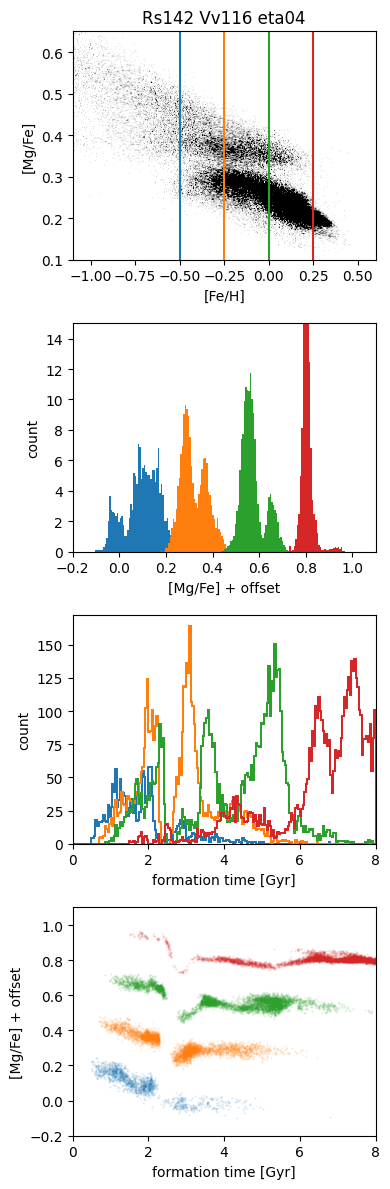

In [43]:
Rs = '142'
Vv = '116'
ecc = '04'
make_plot_iso_sims(Rs, Vv, ecc, save=False, show=True)

In [206]:
# key = 'lvl4-Rs142-Vv116-e04-noAGN'
# gal_noAGN = galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output', 140, orient=True)

# make_plot_iso_sims(None, None, None, save=False, show=True, gal=gal_noAGN)

In [194]:
for Rs in Rs_list:
    for Vv in tqdm(Vv_list):
        for ecc in ecc_list:
            make_plot_iso_sims(Rs, Vv, ecc, save=True, show=False)

100%|██████████| 3/3 [00:11<00:00,  3.68s/it]


# TNG 50 galaxies

In [86]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

def get_rot_pos_vel(snap, subhalo, ptype=4, rhalf_fac=2, phys=False):
    # get COM, COMV, and ang mom of stars
    COM = subhalo['SubhaloPos']
    pos = snap[4]['Coordinates'] - COM
    r = np.linalg.norm(pos, axis=1)
    
    rhalf = subhalo['SubhaloHalfmassRadType'][4]

    in_rhalf = r < rhalf_fac * rhalf
    is_star = snap[4]['GFM_StellarFormationTime'] > 0
    is_star_in_rhalf = np.logical_and(is_star, in_rhalf)
    
    vel_in_rhalf = snap[4]['Velocities'][is_star_in_rhalf]
    mass_in_rhalf = snap[4]['Masses'][is_star_in_rhalf]
    COMV = np.average(vel_in_rhalf, axis=0, weights=mass_in_rhalf)
    
    vel = snap[4]['Velocities'] - COMV
    
    ang = np.cross(pos[is_star_in_rhalf], vel[is_star_in_rhalf])
    ang *= mass_in_rhalf.reshape(-1, 1)
    ang = np.sum(ang, axis=0)
    
    ang_mom = ang

    angmom_dir = ang_mom/np.linalg.norm(ang_mom)
    theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    k = np.cross(ang_mom, np.array([0, 0, 1.]))
    k /= np.linalg.norm(k)

    pos = snap[ptype]['Coordinates'] - COM
    vel = snap[ptype]['Velocities'] - COMV
    mass = snap[ptype]['Masses']
    
    pos_rot = rodrigues_formula(k, pos.astype(np.float64), theta)
    vel_rot = rodrigues_formula(k, vel.astype(np.float64), theta)
    
    if phys:
        pos_rot /= 0.6774
    
    return pos_rot, vel_rot, mass

In [99]:
def make_plot_TNG_sims(subID, logFeH0_list=[-0.5, -0.25, 0, 0.25], dlogFeH0=0.1,
                       logFeH_lim=[-1.1, 0.6], logMgFe_lim=[0.1, 0.65], offset=(-0.3, 0.35),
                       subsamp=5000, save=False, fname=None, show=True):
    
    title='TNG'+str(subID)
    subhalo = il.groupcat.loadSingle(TNGbase, 99, subhaloID=subID)
    snap = {}
    snap[4] = il.snapshot.loadSubhalo(TNGbase, 99, subID, 4)
    
    ### get logFeH and logMgFe ###
    FeH = snap[4]['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
    logFeH = np.log10(FeH)

    MgH = snap[4]['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    ### get in_SN ###
    Lzsun = 8 * 220
    zmax = 3
    dLz = 0.1

    rotpos, rotvel, mass = get_rot_pos_vel(snap, subhalo, phys=True)
    
    Lz = np.cross(rotpos, rotvel)[:,2]
    in_SN = np.logical_and((Lz/Lzsun)-1 < dLz, np.abs(rotpos[:,2]) < zmax)
    
    ### get tform ###
    tform = get_time(snap[4]['GFM_StellarFormationTime'])
    keybool = np.logical_and(in_SN, snap[4]['GFM_StellarFormationTime'] > 0)
    
    ### set fname ###
    if save and fname is None:
        fname = 'fig/TNG'+str(subID)+'.png'
    
    tmax = get_time(1)
    
    make_plot(logFeH, logMgFe, tform, keybool, title, 
              logFeH_lim, logMgFe_lim, logFeH0_list, dlogFeH0,
              offset, subsamp, tmax, save=save, show=show, fname=fname)

In [102]:
TNG_MW_subIDs = np.genfromtxt('TNG_MW_subIDs.txt', dtype='int')

In [101]:
# make_plot_TNG_sims(523889)

In [195]:
for subID in tqdm(TNG_MW_subIDs):
    make_plot_TNG_sims(subID, save=True, show=False)

  0%|          | 0/61 [00:00<?, ?it/s]/tmp/ipykernel_2592162/3239986869.py:27: RuntimeWarning: invalid value encountered in sqrt
  ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))
100%|██████████| 61/61 [03:19<00:00,  3.26s/it]


# ASPCAP plots

In [141]:
hdul = fits.open('../../data/allStar-dr17-synspec_rev1.fits')

In [196]:
# for key in hdul[1].header.keys():
#     if 'TTYPE' in key:
#         print(hdul[1].header[key])

In [153]:
no_starflag = hdul[1].data.STARFLAG == 0
good_snr = hdul[1].data.SNR > 200
good_vscatter = hdul[1].data.VSCATTER < 1
good_parallax = hdul[1].data.GAIAEDR3_PARALLAX/hdul[1].data.GAIAEDR3_PARALLAX_ERROR > 1

aspcap_keys = np.logical_and(no_starflag, good_snr)
aspcap_keys = np.logical_and(aspcap_keys, good_vscatter)
aspcap_keys = np.logical_and(aspcap_keys, good_parallax)

In [159]:
logFeH = hdul[1].data.FE_H[aspcap_keys]
logMgFe = hdul[1].data.MG_FE[aspcap_keys]

logFeH_err = hdul[1].data.FE_H_ERR[aspcap_keys]
logMgFe_err = hdul[1].data.MG_FE_ERR[aspcap_keys]

(-0.2, 0.6)

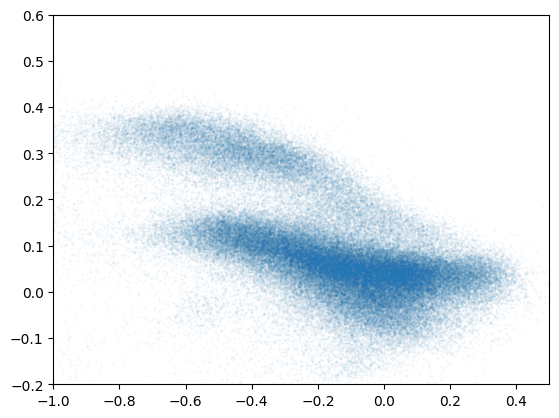

In [160]:
plt.scatter(logFeH, logMgFe, s=0.1, alpha=0.1)
plt.xlim(-1, 0.5)
plt.ylim(-0.2, 0.6)

0.0074705267 0.011654292


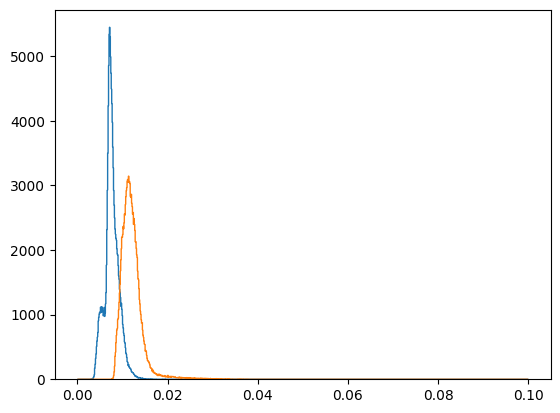

In [169]:
plt.hist(logFeH_err, bins=np.linspace(0, 0.1, 1000), histtype='step');
plt.hist(logMgFe_err, bins=np.linspace(0, 0.1, 1000), histtype='step');

print(np.nanmedian(logFeH_err), np.nanmedian(logMgFe_err))